In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(1, '../quantarhei')
sys.path.insert(2, '../spectre')
import quantarhei as qr
import spectre
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss

In [2]:
#path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode/results_E-ether02-1mode-11010_scanopt_01_2023-07-01_14-14-11/'
#path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/G-scanopt-ether02-1mode-free/results_G-ether02-1mode-free-P-11010_scanopt_01_2023-07-08_02-04-49"
path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/G-scanopt-pyr06-1mode/results_G-pyr06-1mode-P-177_scanopt_01_2023-07-08_02-29-13"

In [36]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

ref_id = 6
ivalue = 1500

lim0 = None
lim1 = None

C:\Users\micha\AppData\Local\Temp\ipykernel_38060\4220794966.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_38060\4220794966.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


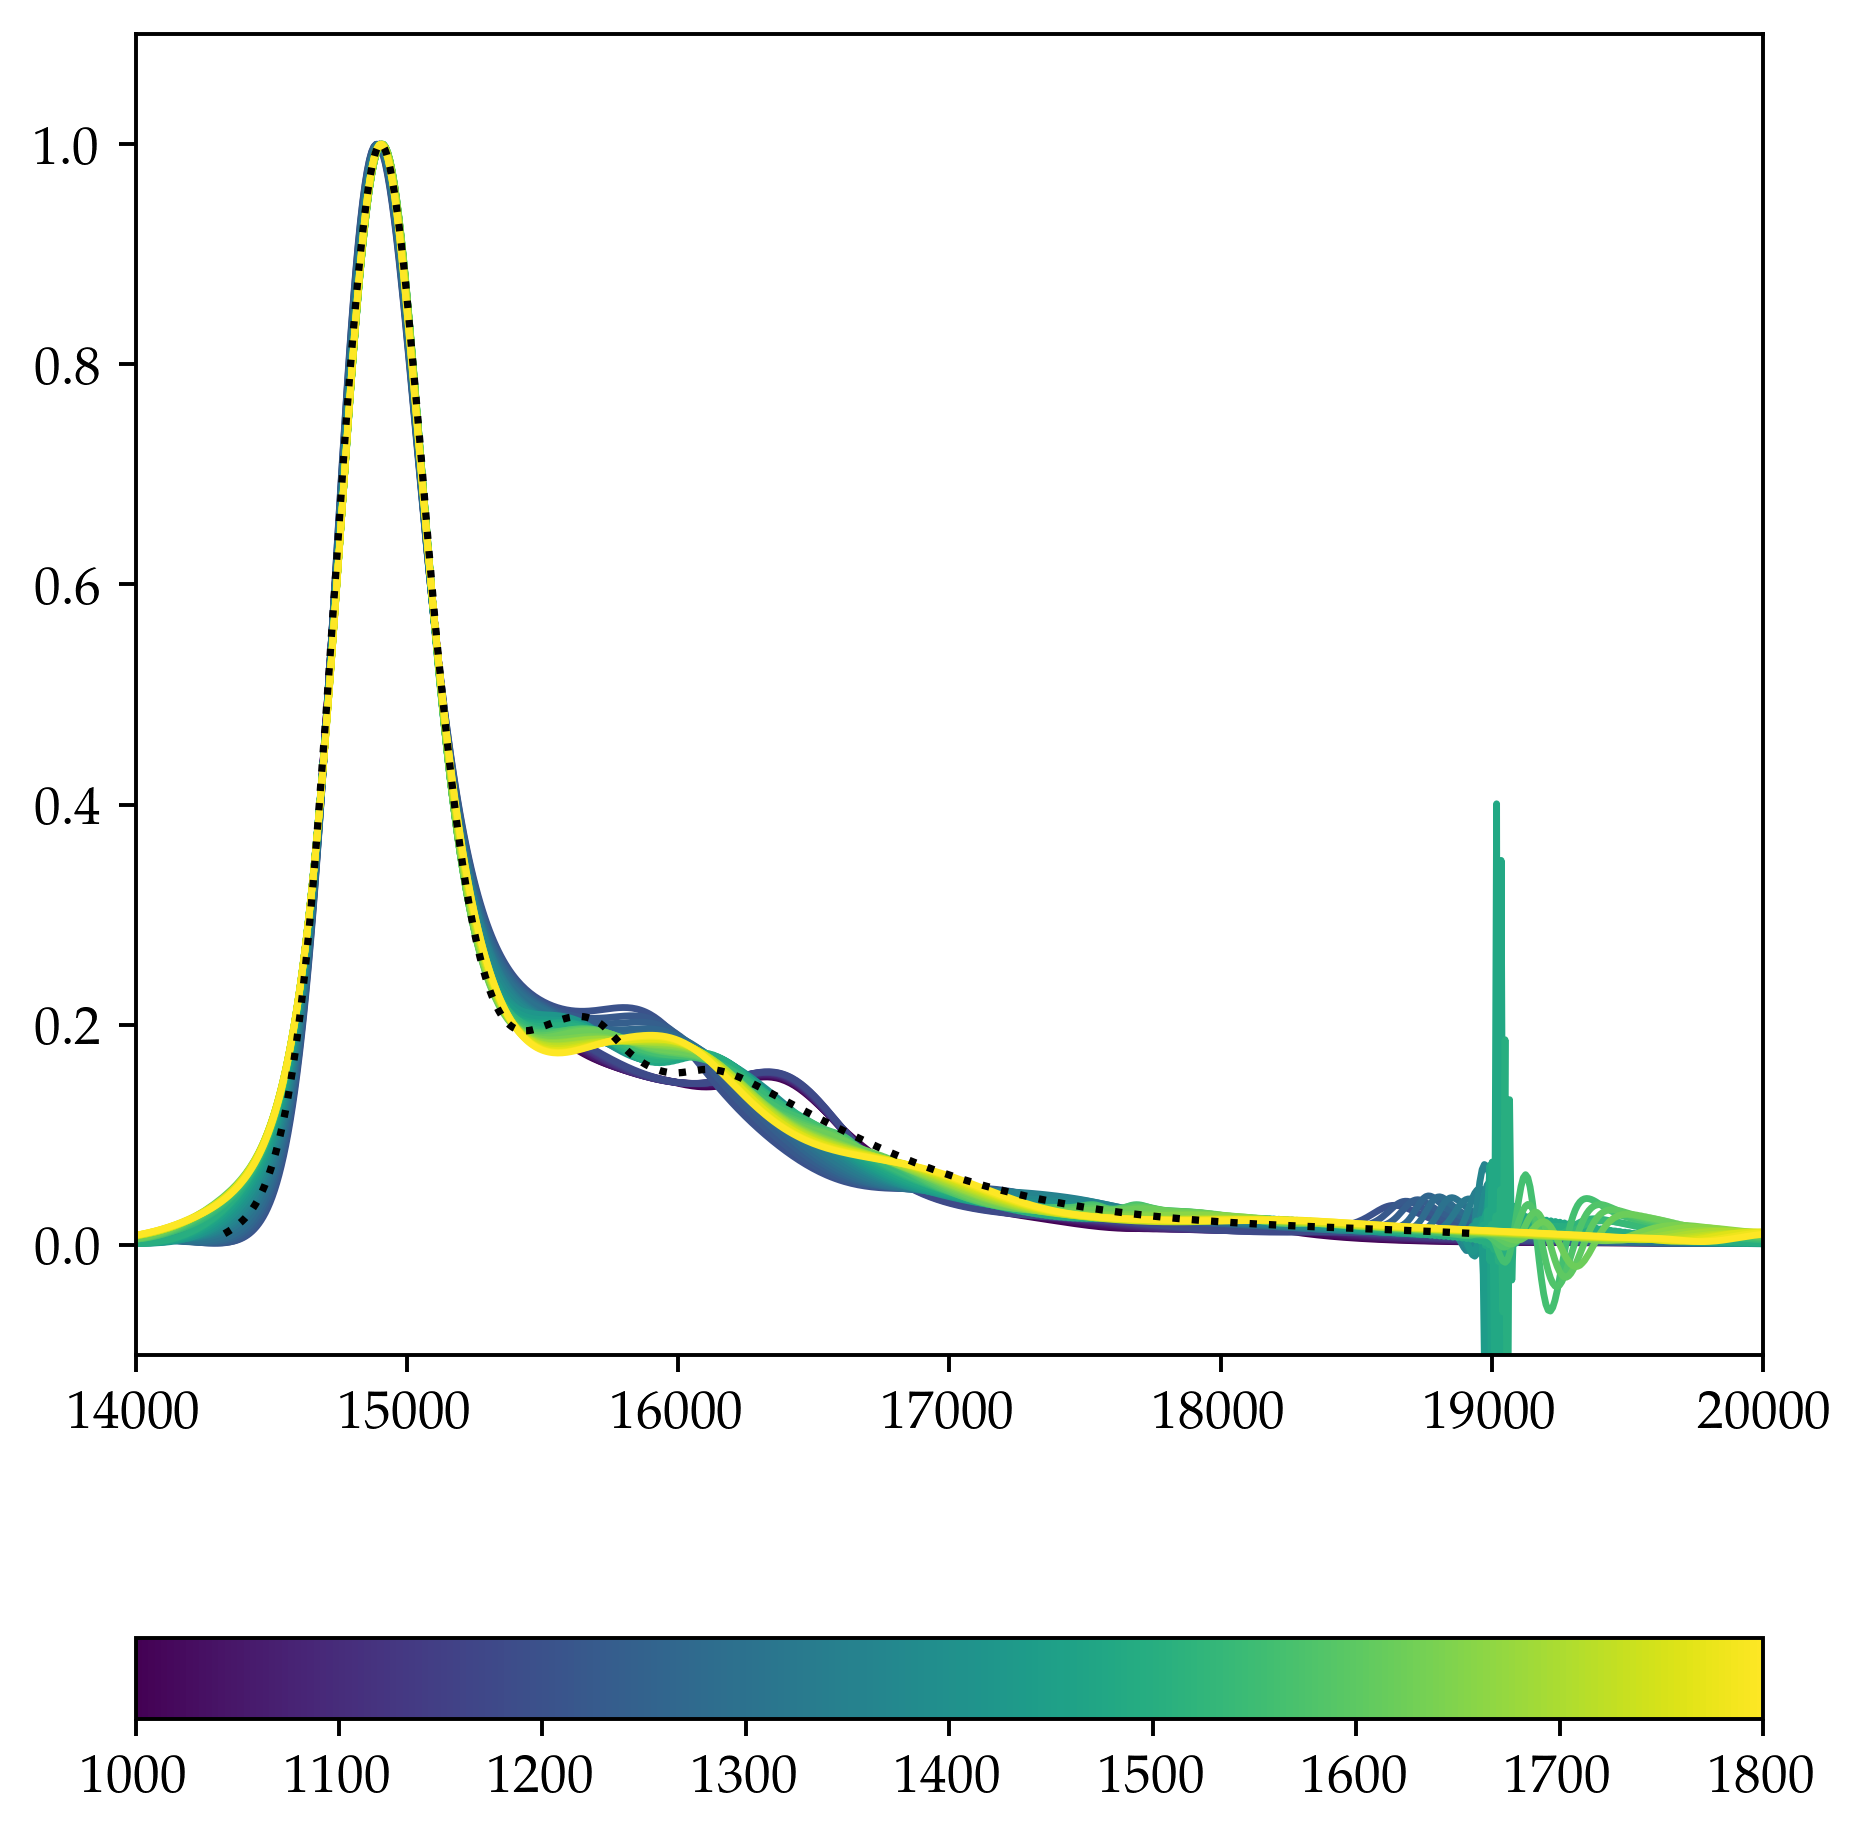

In [37]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(ref_id, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_38060\2906653465.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_38060\2906653465.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])


0.0535563117745


Text(0, 0.5, 'residuum')

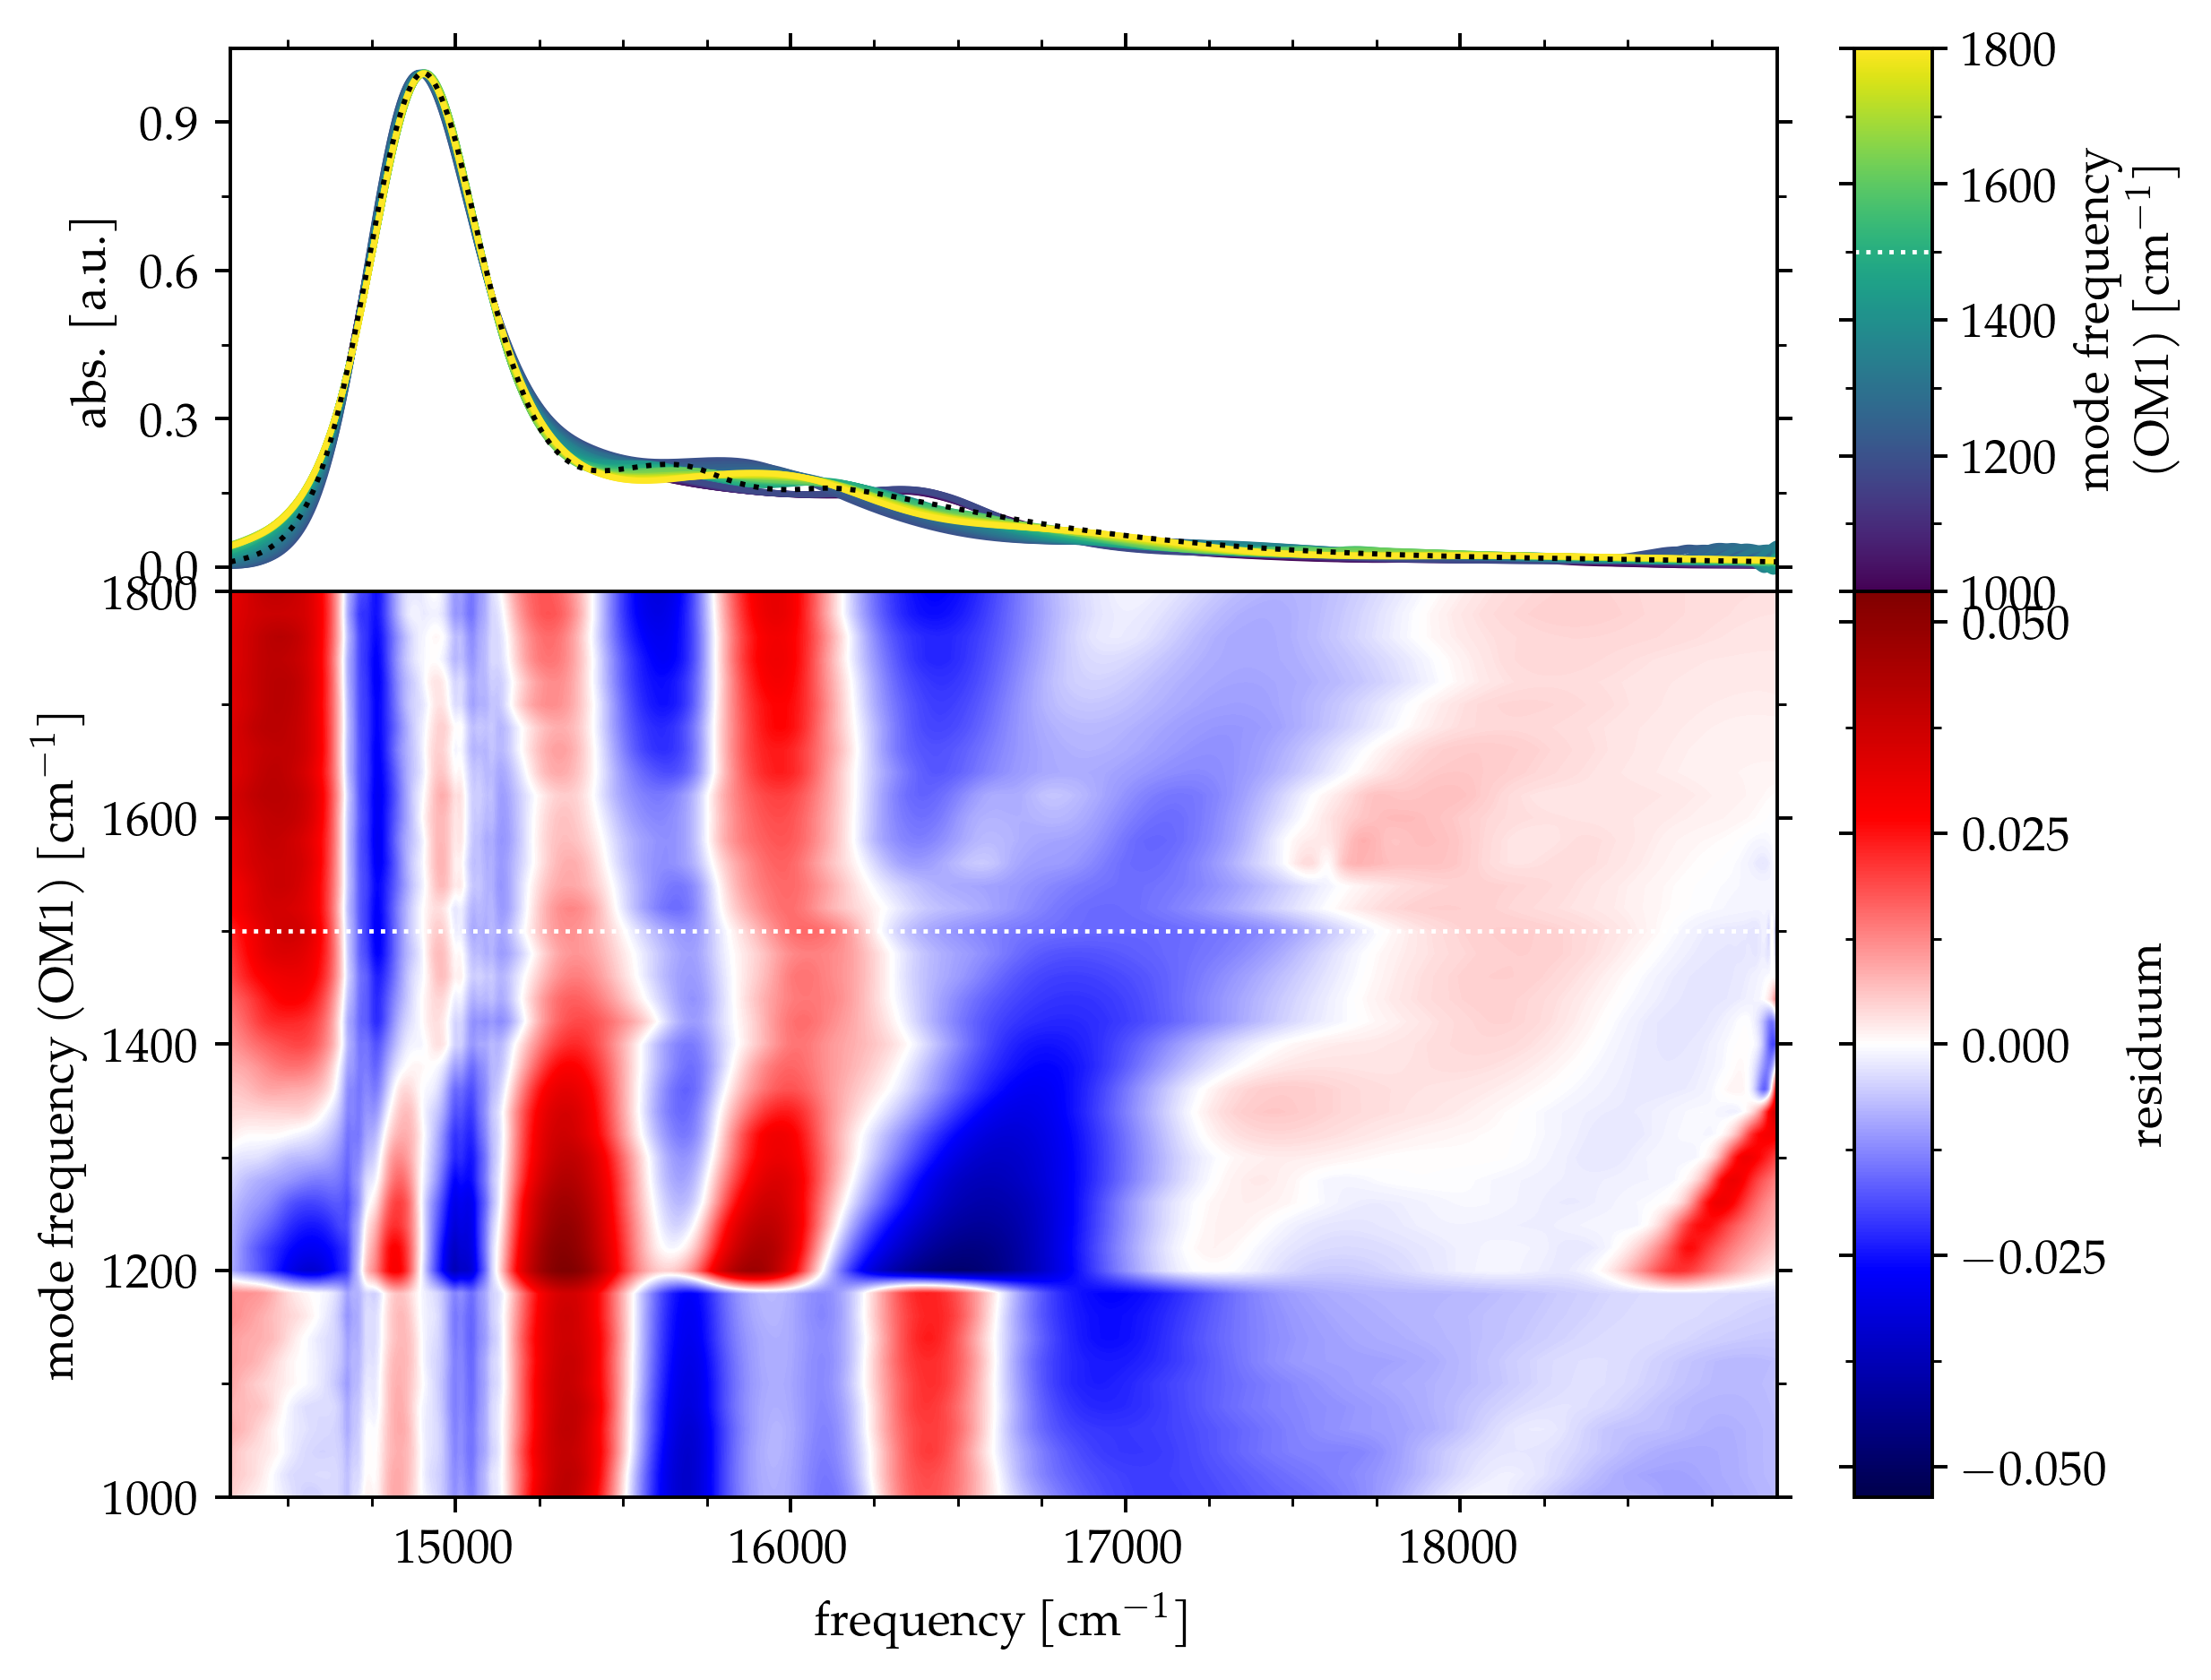

In [40]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)[:,lim0:lim1]

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
print(maximum)

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax0.set_ylim(y[0,0], y[-1,0])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'mode frequency (OM1) [cm$^{-1}$]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering mode frequency (OM1) [cm$^{-1}$]}')
ax4.set_ylabel(r'residuum')

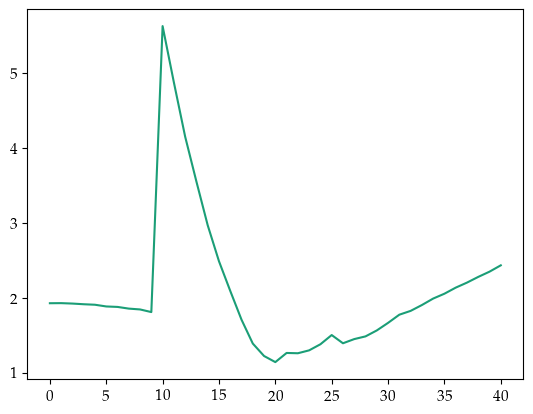

In [41]:
plt.plot((zax**2).sum(axis=1))

In [42]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_38060\530774067.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'mode frequency (OM1) [cm$^{-1}$]')

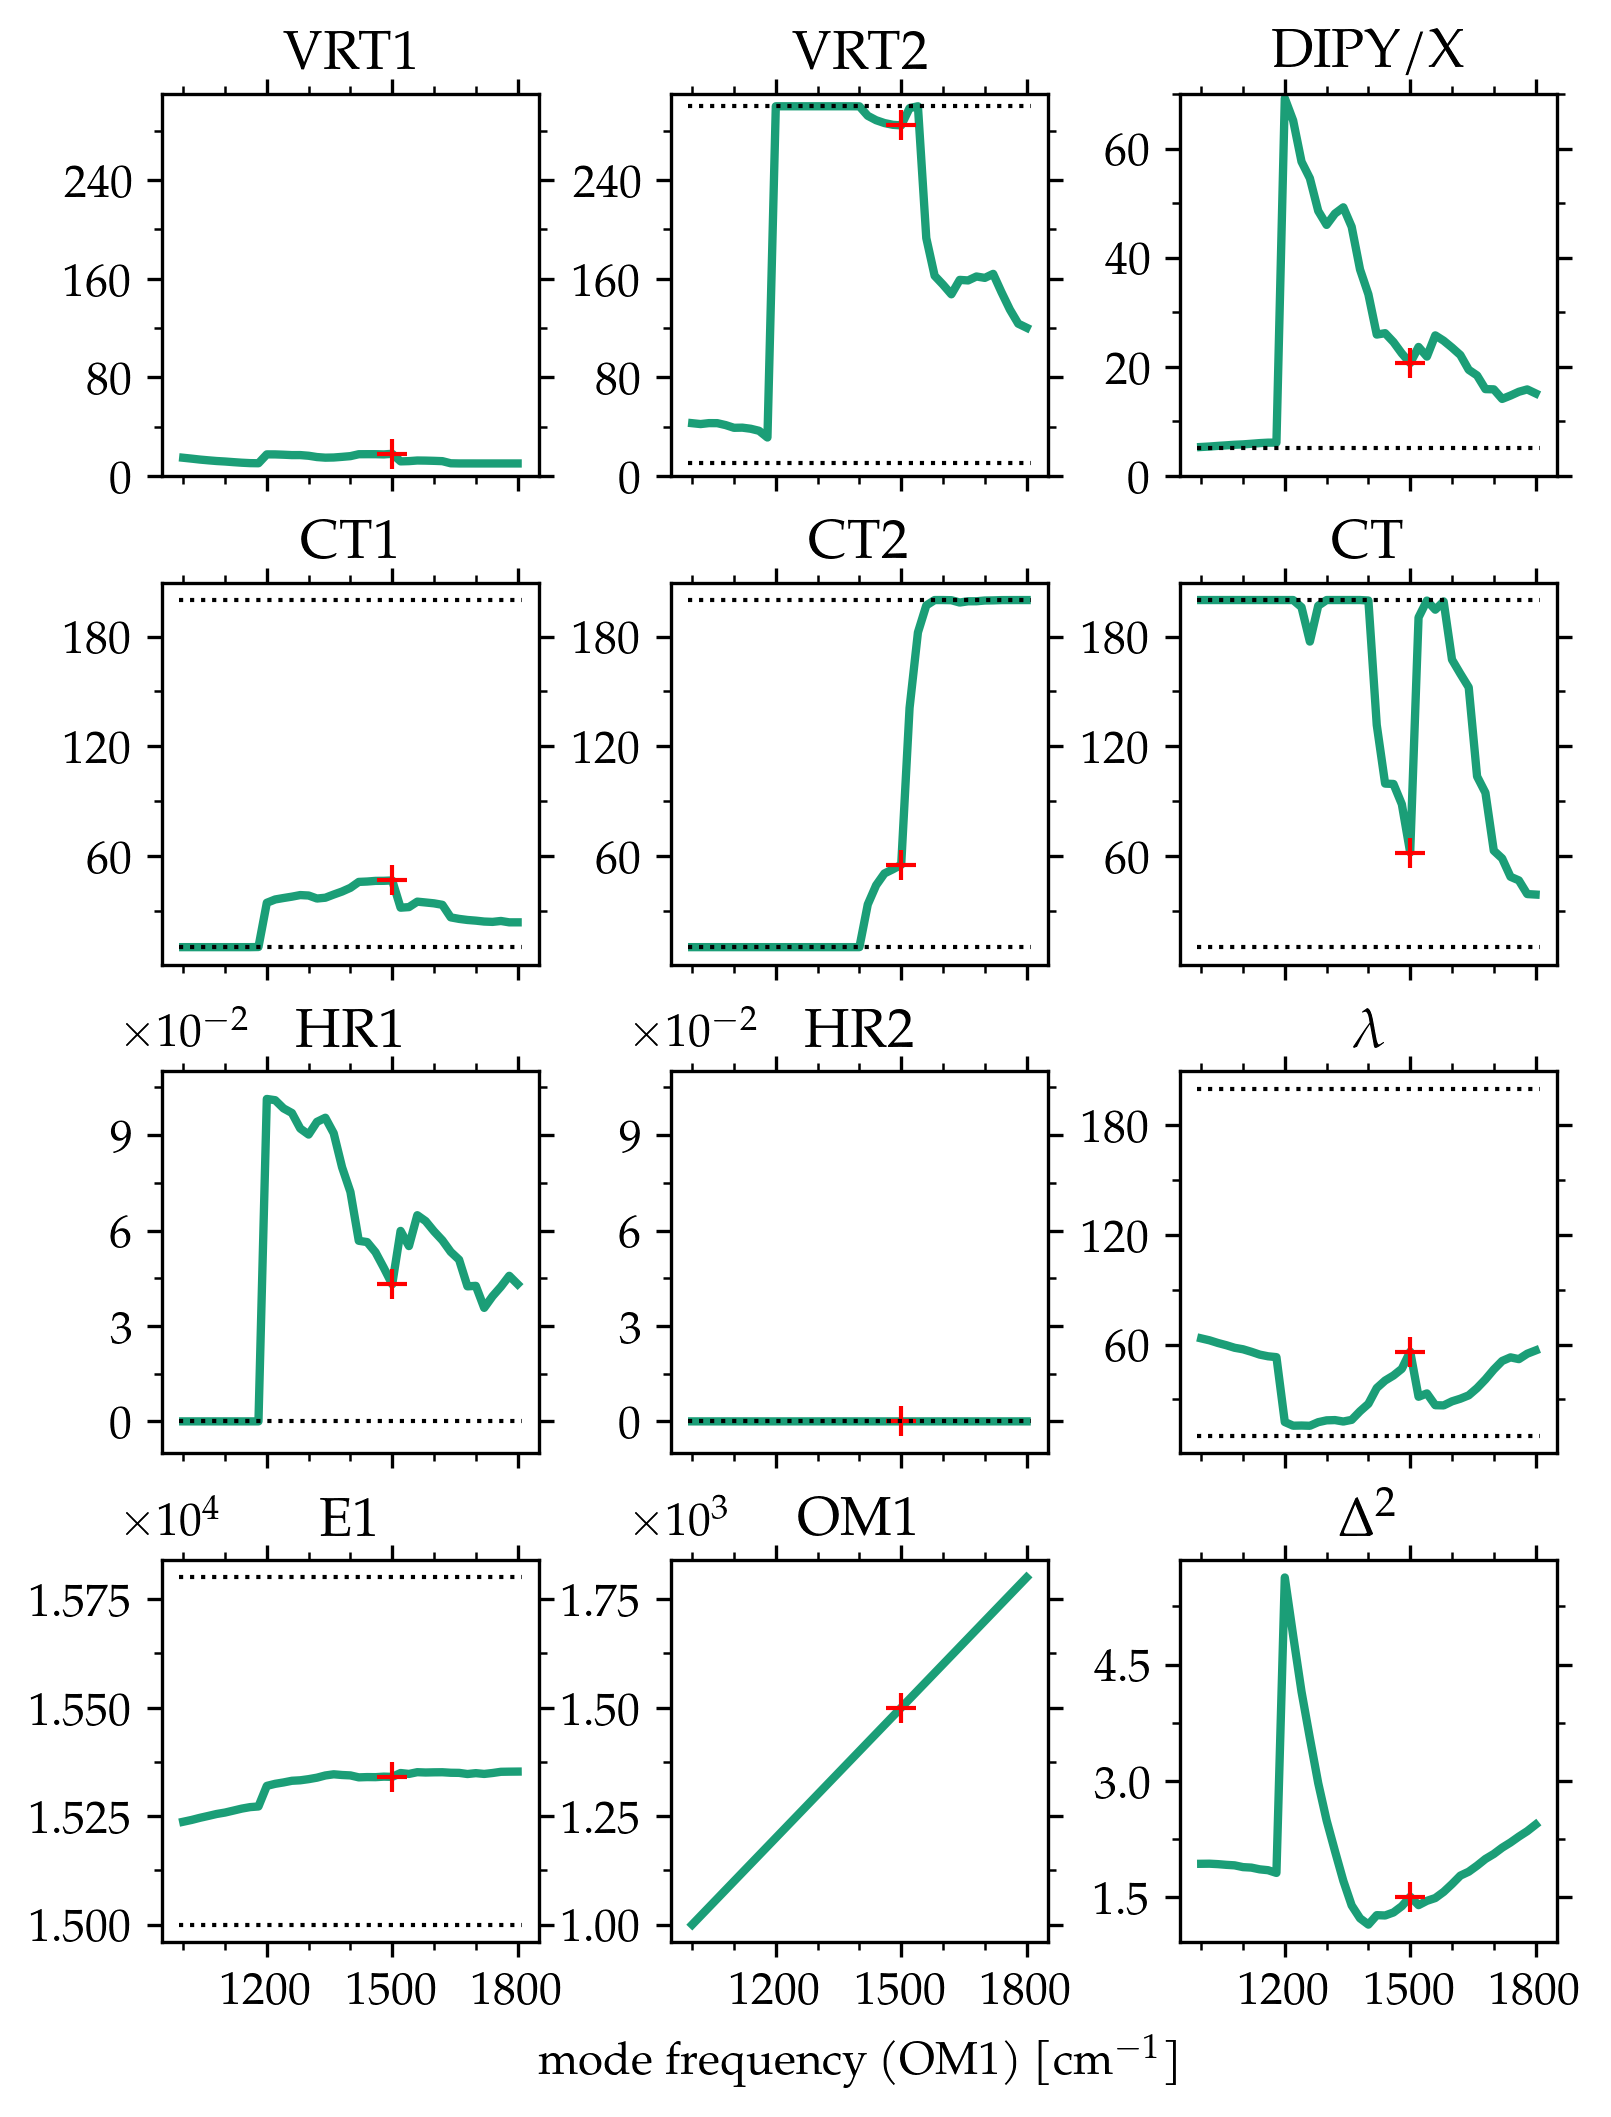

In [44]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[lim0:lim1]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == ivalue][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title('OM1')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    

grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

#grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.11)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

#grid[0,0].set_xlim(10, 80)
grid[0,2].set_ylim(0,70)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(300))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(100))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('mode frequency (OM1) [cm$^{-1}$]')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sys, os
sys.path.insert(1, '../quantarhei')
sys.path.insert(2, '../spectre')
import quantarhei as qr
import spectre
import spectre.full as sef
import spectre.spectroscopy.abs_spectroscopy as abss

# (2.) step 5 - 177

In [5]:
#path = 'C:/Users/micha/Documents/Studium/MScThesis/data-meta/E-scanopt-ether02-1mode/results_E-ether02-1mode-11010_scanopt_01_2023-07-01_14-14-11/'
#path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/G-scanopt-ether02-1mode-free/results_G-ether02-1mode-free-P-11010_scanopt_01_2023-07-08_02-04-49"
path = "C:/Users/micha/Documents/Studium/MScThesis/data-meta/G-scanopt-pyr06-1mode/results_G-pyr06-1mode-s5-P-177_scanopt_01_2023-07-10_10-19-54"

In [6]:
files = [file for file in os.listdir(path) if file.endswith('.json') and file.startswith('opt')]
sfiles = sorted(files, key=lambda s: float(s.split('.')[0].split('_')[2]))

ref_id = 6
ivalue = 1500

lim0 = None
lim1 = None

C:\Users\micha\AppData\Local\Temp\ipykernel_14540\4220794966.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Reorg: 431.53930447
Reorg: 156.10192166
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.1s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 5.27s
Reorg: 438.837870129
Reorg: 157.911166337
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.64s
Reorg: 446.666707684
Reorg: 157.245453879
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.56s
Reorg: 455.060707926
Reorg: 154.374474281
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.43s
Reorg: 459.324266862
Reorg: 163.098447169
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.64s
Reorg: 472.004388725
Reorg: 152.135022624
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.45s
Reorg: 479.273016414
Reorg: 152.567012827
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.57s
Reorg: 486.523325963
Reorg: 153.042390337
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.53s
Reorg: 495.903358729
Reorg: 152.660316585
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.17s
Spectrum calculation (CPU): 4.64s
Reorg: 500.821868678
Reorg: 158.181979049
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.70s
Reorg: 506.716359351
Reorg: 161.59554196
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.51s
Reorg: 518.863032782
Reorg: 153.957824193
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.18s
Spectrum calculation (CPU): 4.41s
Reorg: 526.577703424
Reorg: 154.593281594
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 4.55s
Reorg: 534.531054811
Reorg: 155.68832257
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.53s
Reorg: 542.059856952
Reorg: 155.553771217
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.49s
Reorg: 543.899061455
Reorg: 173.817983335
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.51s
Reorg: 557.762250169
Reorg: 162.409062489
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.55s
Reorg: 555.937542923
Reorg: 180.600406994
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.24s
Spectrum calculation (CPU): 4.28s
Reorg: 572.548482135
Reorg: 165.454875726
System init: 5.00s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.39s
Reorg: 577.688685384
Reorg: 171.158471304
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.50s
Reorg: 583.761910292
Reorg: 173.62331637
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.49s
Reorg: 594.812072057
Reorg: 170.172075915
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.45s
Reorg: 601.12150181
Reorg: 175.230996255
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.51s
Reorg: 608.328066616
Reorg: 177.956036727
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.48s
Reorg: 628.972131179
Reorg: 157.380036148
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.43s
Reorg: 623.83013751
Reorg: 182.780825263
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.44s
Reorg: 633.970121452
Reorg: 180.377672865
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.49s
Reorg: 639.736361053
Reorg: 185.17718168
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.41s
Reorg: 652.796799972
Reorg: 181.32220444
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.53s
Reorg: 656.967187876
Reorg: 188.812851646
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.44s
Reorg: 659.769292125
Reorg: 199.455369209
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.45s
Reorg: 669.382352451
Reorg: 198.154734887
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.36s
Reorg: 682.236530418
Reorg: 192.147254921
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.37s
Reorg: 680.625693448
Reorg: 210.397272268
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.46s
Reorg: 686.055233992
Reorg: 220.247403931
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.52s
Reorg: 695.548685426
Reorg: 222.418434208
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.42s
Reorg: 700.192031976
Reorg: 227.570167663
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.51s
Reorg: 710.685484859
Reorg: 228.515436512
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.41s
Reorg: 712.741241128
Reorg: 241.402842382
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.55s
Reorg: 714.800218454
Reorg: 252.818762304
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.53s
Reorg: 1173.11713484
Reorg: 23.8954128744
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.63s
Reorg: 1193.21030626
Reorg: 23.9642571283
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.22s
Spectrum calculation (CPU): 4.35s
Reorg: 1212.50130836
Reorg: 24.0332057033
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.60s
Reorg: 1244.737695
Reorg: 24.1022576076
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.36s
Reorg: 1268.42206466
Reorg: 24.1714118594
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.50s
Reorg: 1296.94084391
Reorg: 24.2406674913
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.31s
Reorg: 1314.56875267
Reorg: 24.3100235453
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.45s
Reorg: 1335.93913597
Reorg: 24.3794790783
System init: 4.80s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.68s
Reorg: 1349.37092071
Reorg: 24.4490331574
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.36s
Reorg: 1360.63830109
Reorg: 24.5186848657
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.38s
Reorg: 1379.46189874
Reorg: 24.5884332895
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.30s
Reorg: 1396.36471335
Reorg: 24.6582775364
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.44s
Reorg: 1414.04806517
Reorg: 24.7282167148
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.36s
Reorg: 1421.73759977
Reorg: 24.7982499544
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.52s
Reorg: 1440.3806447
Reorg: 24.8683763854
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.51s
Reorg: 1466.53339568
Reorg: 24.9385951573
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.47s
Reorg: 1482.38292982
Reorg: 25.0089054251
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.45s
Reorg: 1499.16581273
Reorg: 25.0793063552
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.44s
Reorg: 1515.41647941
Reorg: 25.149797124
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.46s
Reorg: 1530.99237729
Reorg: 25.2203769178
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.61s
Reorg: 1546.48949601
Reorg: 25.2910449342
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.50s
Reorg: 1562.55499212
Reorg: 25.361800374
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.17s
Spectrum calculation (CPU): 4.49s
Reorg: 1583.91394191
Reorg: 25.4326424587
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.52s
Reorg: 1601.85862682
Reorg: 25.5035704059
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.44s
Reorg: 1638.20276937
Reorg: 25.5745834549
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.53s
Reorg: 1665.45286734
Reorg: 25.6456812294
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.21s
Spectrum calculation (CPU): 4.39s
Reorg: 1715.58579205
Reorg: 25.7169696499
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.58s
Reorg: 1735.28447697
Reorg: 25.7883105114
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.64s
Reorg: 1756.73606184
Reorg: 25.8597878016
System init: 4.81s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.44s
Reorg: 1767.15655899
Reorg: 25.9308989691
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.45s
Reorg: 1779.15980437
Reorg: 26.0024070019
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.48s
Reorg: 1791.66024256
Reorg: 26.0739950594
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.43s
Reorg: 1800.81897844
Reorg: 26.1456700041
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.64s
Reorg: 1815.32811426
Reorg: 26.217428443
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.36s
Reorg: 1888.2323598
Reorg: 26.289233162
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.58s
Reorg: 1895.06265327
Reorg: 26.3611340362
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.51s
Reorg: 1903.81840136
Reorg: 26.5295957554
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.55s
Reorg: 1912.2450152
Reorg: 26.5051640103
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.42s
Reorg: 1922.11568424
Reorg: 26.5773440871
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.63s
Reorg: 1945.90379867
Reorg: 56.3348919236
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.60s
Reorg: 1939.28100346
Reorg: 71.3849476031
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.39s
Reorg: 1959.71495359
Reorg: 71.7762884649
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.65s
Reorg: 1982.60291699
Reorg: 72.1587464642
System init: 5.02s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.19s
Spectrum calculation (CPU): 4.61s
Reorg: 1942.77347692
Reorg: 65.5586415158
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.71s
Reorg: 1958.17424353
Reorg: 70.0049356213
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.61s
Reorg: 1941.84302155
Reorg: 111.600484299
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.08s
Spectrum calculation (CPU): 4.54s
Reorg: 1955.50700102
Reorg: 111.990267256
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.66s
Reorg: 1961.51604903
Reorg: 115.051473876
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.56s
Reorg: 1893.53367677
Reorg: 137.42983825
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.61s
Reorg: 1902.61960613
Reorg: 137.91127467
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.22s
Spectrum calculation (CPU): 4.65s
Reorg: 1914.07568881
Reorg: 139.921651589
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.57s
Reorg: 1922.28214855
Reorg: 142.342590961
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.44s
Reorg: 1935.61381967
Reorg: 143.125032317
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.55s
Reorg: 1952.88447341
Reorg: 143.827060631
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.53s
Reorg: 1968.13382869
Reorg: 144.578759682
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.67s
Reorg: 1975.42166221
Reorg: 145.162880723
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.33s
Reorg: 1975.96181543
Reorg: 144.216794825
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.49s
Reorg: 1970.60928279
Reorg: 144.883221186
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.44s
Reorg: 1977.69270813
Reorg: 145.66915108
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.66s
Reorg: 1978.03185131
Reorg: 146.040288504
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.72s
Reorg: 1969.76180951
Reorg: 146.072659685
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.58s
Reorg: 1979.86929536
Reorg: 146.166344997
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.39s
Reorg: 2075.94169075
Reorg: 272.255346053
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.69s
Reorg: 2097.17286685
Reorg: 269.049352618
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.51s
Reorg: 2120.71291348
Reorg: 270.362789809
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.64s
Reorg: 2147.55685781
Reorg: 274.711245732
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.66s
Reorg: 2148.96864443
Reorg: 387.362286434
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.57s
Reorg: 2163.02545237
Reorg: 388.664215588
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.63s
Reorg: 2169.99489748
Reorg: 389.93563125
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.51s
Reorg: 2172.74753894
Reorg: 759.784391838
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 4.58s
Reorg: 2186.34786253
Reorg: 762.250688454
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.6s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.78s
Reorg: 2196.66014927
Reorg: 823.029418517
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.56s
Reorg: 2207.3744131
Reorg: 868.288074987
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.51s
Reorg: 2216.32099414
Reorg: 880.81187295
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.20s
Spectrum calculation (CPU): 4.73s
Reorg: 2222.28464597
Reorg: 890.45270324
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.51s
Reorg: 2233.25499854
Reorg: 909.575832858
System init: 4.93s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.72s
Reorg: 2245.84570488
Reorg: 949.156534502
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.57s
Reorg: 2255.4727496
Reorg: 1003.3512691
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.42s
Reorg: 2261.55825955
Reorg: 1018.65648643
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.47s
Reorg: 2258.58789031
Reorg: 1030.76834255
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.66s
Reorg: 2270.82349893
Reorg: 1066.84874055
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.71s
Reorg: 2283.57119021
Reorg: 1099.39311558
System init: 4.81s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.74s
Reorg: 2238.5662759
Reorg: 1049.75806108
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.43s
Reorg: 2215.16679501
Reorg: 998.202103522
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.64s
Reorg: 2219.27528756
Reorg: 1017.50047693
System init: 4.81s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.50s
Reorg: 2162.21312717
Reorg: 925.912686038
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.61s
Reorg: 2154.30122772
Reorg: 929.391469925
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.42s
Reorg: 2105.49647175
Reorg: 916.537005016
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.43s
Reorg: 2124.91083158
Reorg: 956.305156073
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.50s
Reorg: 2174.76980986
Reorg: 1024.55375241
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.55s
Reorg: 2161.81473008
Reorg: 1028.26181841
System init: 4.97s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 4.67s
Reorg: 2163.18096973
Reorg: 1085.86073546
System init: 4.91s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.50s
Reorg: 2130.84300028
Reorg: 1066.09230678
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.46s
Reorg: 2141.97065117
Reorg: 1069.90343001
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.49s
Reorg: 2163.09949644
Reorg: 1077.12749289
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.31s
Reorg: 2079.83268135
Reorg: 989.376364912
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.60s
Reorg: 2112.1164835
Reorg: 1002.42216102
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 4.65s
Reorg: 2103.48766911
Reorg: 1029.24591576
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.50s
Reorg: 2121.22540052
Reorg: 1018.94784089
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.15s
Spectrum calculation (CPU): 4.51s
Reorg: 2148.61618874
Reorg: 1034.61744108
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.70s
Reorg: 2111.97380695
Reorg: 1081.48945009
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.74s
Reorg: 2125.42870607
Reorg: 1108.04076264
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.73s
Reorg: 2135.53342857
Reorg: 1112.2004809
System init: 4.85s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.61s
Reorg: 2136.84044078
Reorg: 1117.21181721
System init: 4.83s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.64s
Reorg: 2084.06576786
Reorg: 1062.34084738
System init: 4.82s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.65s
Reorg: 2101.42913215
Reorg: 1077.73882719
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.4s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.60s
Reorg: 2142.97771119
Reorg: 1191.73214489
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.48s
Reorg: 2104.24269288
Reorg: 1182.8466523
System init: 4.87s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.0s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.22s
Reorg: 2100.30050073
Reorg: 1176.07974701
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.37s
Reorg: 2094.60775155
Reorg: 1159.38543545
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.11s
Spectrum calculation (CPU): 4.44s
Reorg: 2103.22218569
Reorg: 1168.59064764
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.13s
Spectrum calculation (CPU): 4.32s
Reorg: 2147.2168709
Reorg: 1290.57155592
System init: 4.90s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.29s
Reorg: 2159.72555022
Reorg: 1336.67076444
System init: 4.86s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.27s
Reorg: 2161.96234421
Reorg: 1356.76999283
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.43s
Reorg: 2193.2255256
Reorg: 1399.00049921
System init: 4.84s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.17s
Spectrum calculation (CPU): 4.47s
Reorg: 2169.25953629
Reorg: 1502.47036037
System init: 4.88s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


Tensor calculation: 1.12s
Spectrum calculation (CPU): 4.47s
Reorg: 2159.47981785
Reorg: 1472.5581349
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.10s
Spectrum calculation (CPU): 4.55s
Reorg: 2163.57057233
Reorg: 1477.32552637
System init: 4.92s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.47s
Reorg: 2158.38175394
Reorg: 1501.01444221
System init: 4.96s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.1s finished


Tensor calculation: 1.09s
Spectrum calculation (CPU): 4.29s
Reorg: 2156.18271952
Reorg: 1550.57471941
System init: 4.94s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.3s finished


Tensor calculation: 1.16s
Spectrum calculation (CPU): 4.55s
Reorg: 2169.20999212
Reorg: 1583.59584987
System init: 4.89s


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished
C:\Users\micha\AppData\Local\Temp\ipykernel_14540\4220794966.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal')


Tensor calculation: 1.14s
Spectrum calculation (CPU): 4.41s


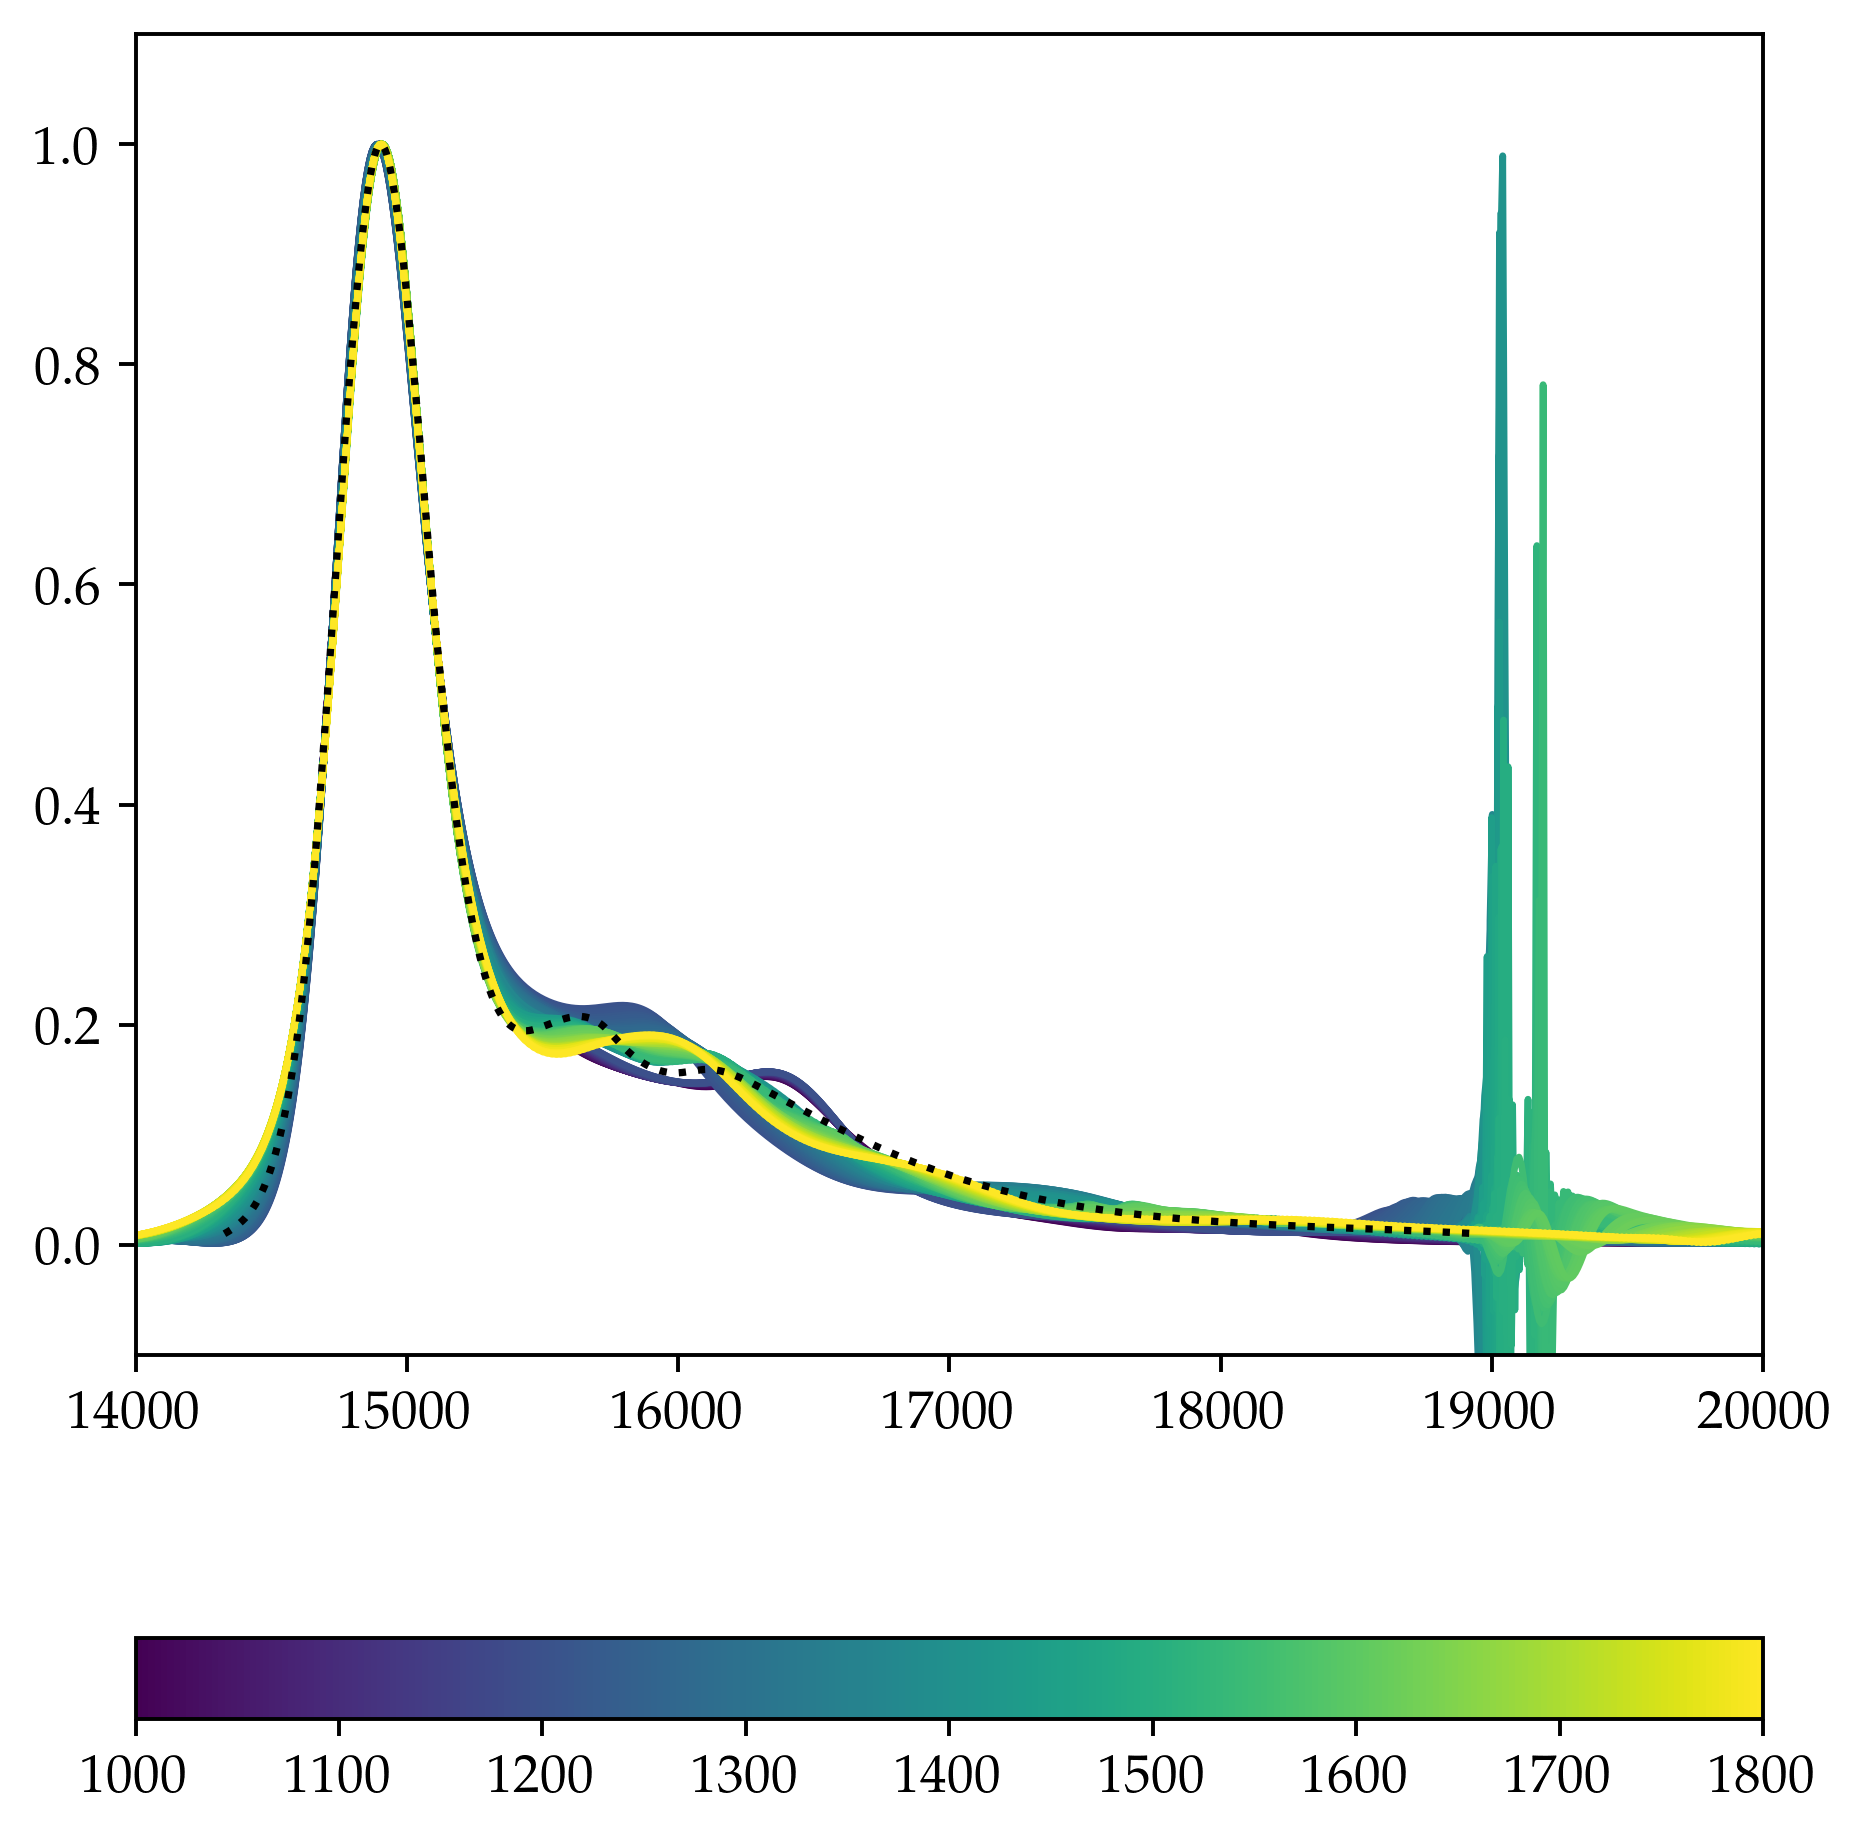

In [7]:
from matplotlib import cm
clm = cm.get_cmap('viridis', len(files))

fig, ax = plt.subplots(figsize=(6,7), dpi= 350)
labels = list()

for i, f in enumerate(sfiles[:]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    plt.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
    labels.append(lab)

plt.xlim(14000, 20000)
plt.ylim(-0.1, 1.1)
#plt.legend(frameon=False)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(labels[0], labels[-1]))
cbar = plt.colorbar(sm, orientation='horizontal')
#cbar.set_ticklabels(labs)

abss.plot_ref(ref_id, plot_to=ax, color='k', linestyle = 'dotted')

C:\Users\micha\AppData\Local\Temp\ipykernel_14540\2906653465.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))
C:\Users\micha\AppData\Local\Temp\ipykernel_14540\2906653465.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot(gs[3])
100%|███████████████████████████████████████████████████████████████████████████████████| 161/161 [00:04<00:00, 33.86it/s]


0.0949341614831


Text(0, 0.5, 'residuum')

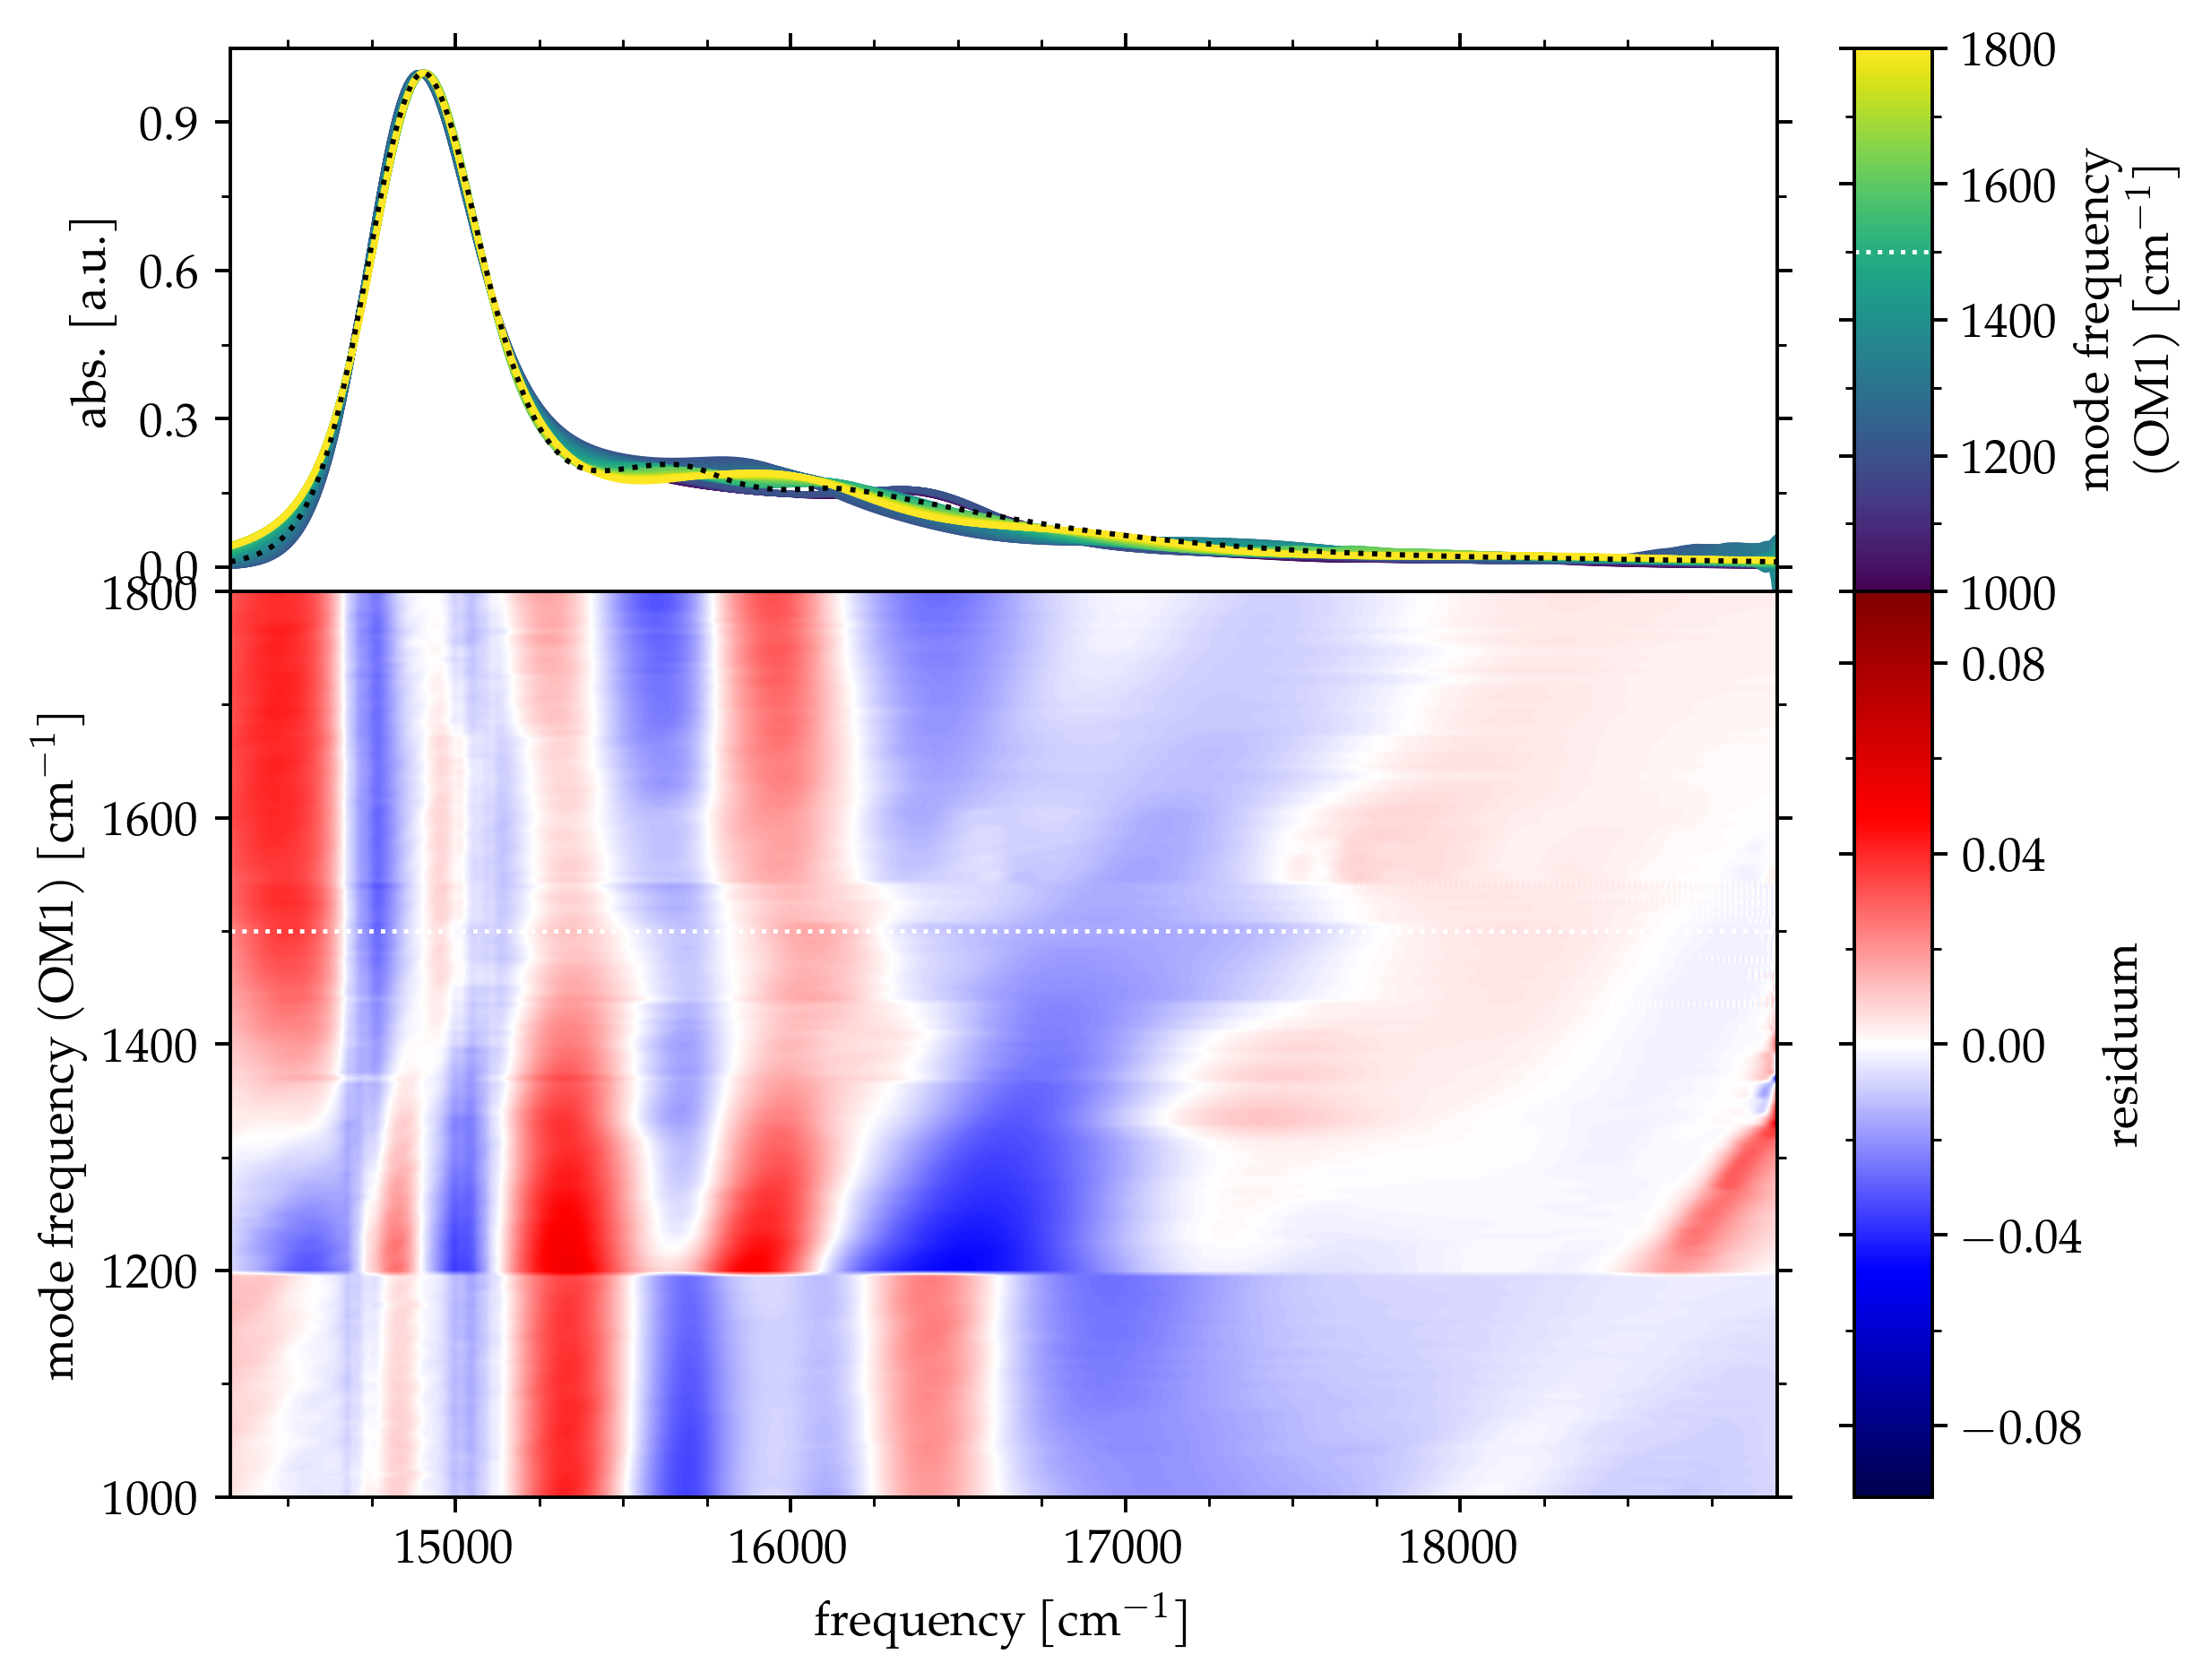

In [8]:
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
from matplotlib import gridspec

spline_s=0.0002
spline_k=3

clm = cm.get_cmap('viridis', len(files))

refdata = abss.plot_ref(ref_id, return_data='data', plot=False)
refx, refy = refdata

fig, ax = plt.subplots(num=None, figsize=(7,6), dpi=350, facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 0.05, 0.05), height_ratios=(0.6, 1), figure=fig) 
#ax3 = plt.subplot(gs[3])
ax0 = plt.subplot(gs[3])
ax1 = plt.subplot(gs[0], sharex = ax0)
ax4 = plt.subplot(gs[5])
ax2 = plt.subplot(gs[2])
plt.subplots_adjust(hspace=0, wspace=0)

####################
#   ax1   #  # ax2 #
####################
#   ax0   #  # ax4 #
####################

all_data_filename = 'all_data.npy'
all_data_path = os.path.join(path, all_data_filename)

if os.path.isfile(all_data_path) and True:
    x, y, zdata = np.load(all_data_path)[:,lim0:lim1]

    for i, z in enumerate(zdata):
        ax1.plot(x[i], z, linewidth=1.4, color=clm(i))
    
    zax = zdata - refy

else:
    labels = list()
    zax = None
    zdata = None
    i = 0

    for f in tqdm(sfiles[:]):
        i += 1
        filepath = os.path.join(path, f)
        optpars = spectre.utils.loadjson(filepath)
        datapath = filepath.replace('.json', '.npy')
        
        if os.path.isfile(datapath):
            data = np.load(datapath)
        else:
            syst, ta = spectre.full.init_system(optpars)
            spec = abss.calculate_abs_spectrum(syst, ta, optpars)
            spec.normalize()
            
            with qr.energy_units('1/cm'):
                data = np.vstack([spec.axis.data, spec.data])
                np.save(datapath, data)
    
        lab = f.split('.')[0].split('_')[2]
        spline = UnivariateSpline(*data, k=spline_k, s=spline_s)
        ydat = spline(refx) - refy
        
        if zax is None:
            zax = ydat
            zdata = spline(refx)
        else:
            zax = np.vstack([zax, ydat])
            zdata = np.vstack([zdata, spline(refx)])
        
        ax1.plot(data[0], data[1], label=lab, linewidth=1.4, color=clm(i))
        labels.append(float(lab))

    yax = np.array(labels)
    xax = refx
    x, y = np.meshgrid(xax, yax)
    np.save(all_data_path, np.array([x, y, zdata]))

maximum = np.abs(zax).max()
print(maximum)

cf = ax0.contourf(x, y, zax, 500, cmap="seismic", vmax=maximum, vmin=-maximum)

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(-maximum, maximum))
cbar = plt.colorbar(sm, cax=ax4, orientation='vertical')

sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(y[0,0], y[-1,0]))
cbar2 = plt.colorbar(sm2, cax=ax2, orientation='vertical')

ax0.plot([x[0,0], x[0,-1]], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')
ax2.plot([0, 1], [ivalue,ivalue], linewidth=1, linestyle='dotted', c='w')

abss.plot_ref(ref_id, plot_to=ax1, linestyle='dotted', c='k', linewidth=1.2)

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in [ax0, ax1, ax2, ax4]:
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    g.tick_params(which='both', **pars)
    
    #g.xaxis.set_major_locator(MultipleLocator(20))
    #g.xaxis.set_major_formatter('{x:.0f}')
    #g.xaxis.set_minor_locator(MultipleLocator(10))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.xaxis.set_minor_locator(AutoMinorLocator(4))
    #g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    #g.get_yaxis().set_offset_position("left")
    #g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.097,0))

ax4.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax0.tick_params(which='both', labelbottom=True, labelleft=True)
ax1.tick_params(which='both', bottom=False)
ax2.tick_params(which='both', labelleft=False, labelright=True)
ax4.tick_params(which='both', labelleft=False, labelright=True)

ax0.set_xlim(x[0,0], x[0,-1])
ax0.set_ylim(y[0,0], y[-1,0])
ax1.set_ylim(-0.05, 1.05)

ax0.set_xlabel(r'frequency [cm$^{-1}$]')
ax0.set_ylabel(r'mode frequency (OM1) [cm$^{-1}$]')
ax1.set_ylabel(r'abs. [a.u.]')
ax2.set_ylabel(r'\parbox{40mm}{\centering mode frequency (OM1) [cm$^{-1}$]}')
ax4.set_ylabel(r'residuum')

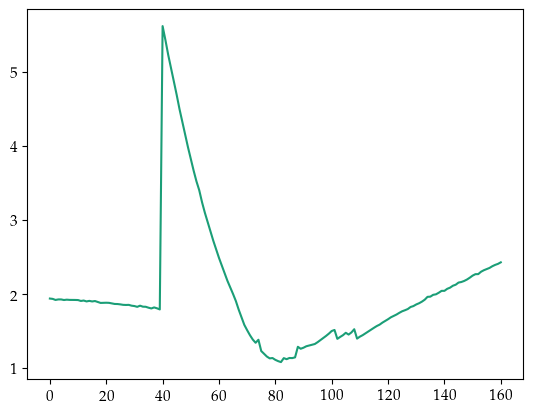

In [9]:
plt.plot((zax**2).sum(axis=1))

In [10]:
def draw_line(plot_to, xaxis, *vals, **pars):
    for val in vals:
        plot_to.plot([xaxis[0]-10, xaxis[-1]+10], [val, val], **pars)

C:\Users\micha\AppData\Local\Temp\ipykernel_14540\530774067.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clm = cm.get_cmap('viridis', len(files))


Text(0.5, 0, 'mode frequency (OM1) [cm$^{-1}$]')

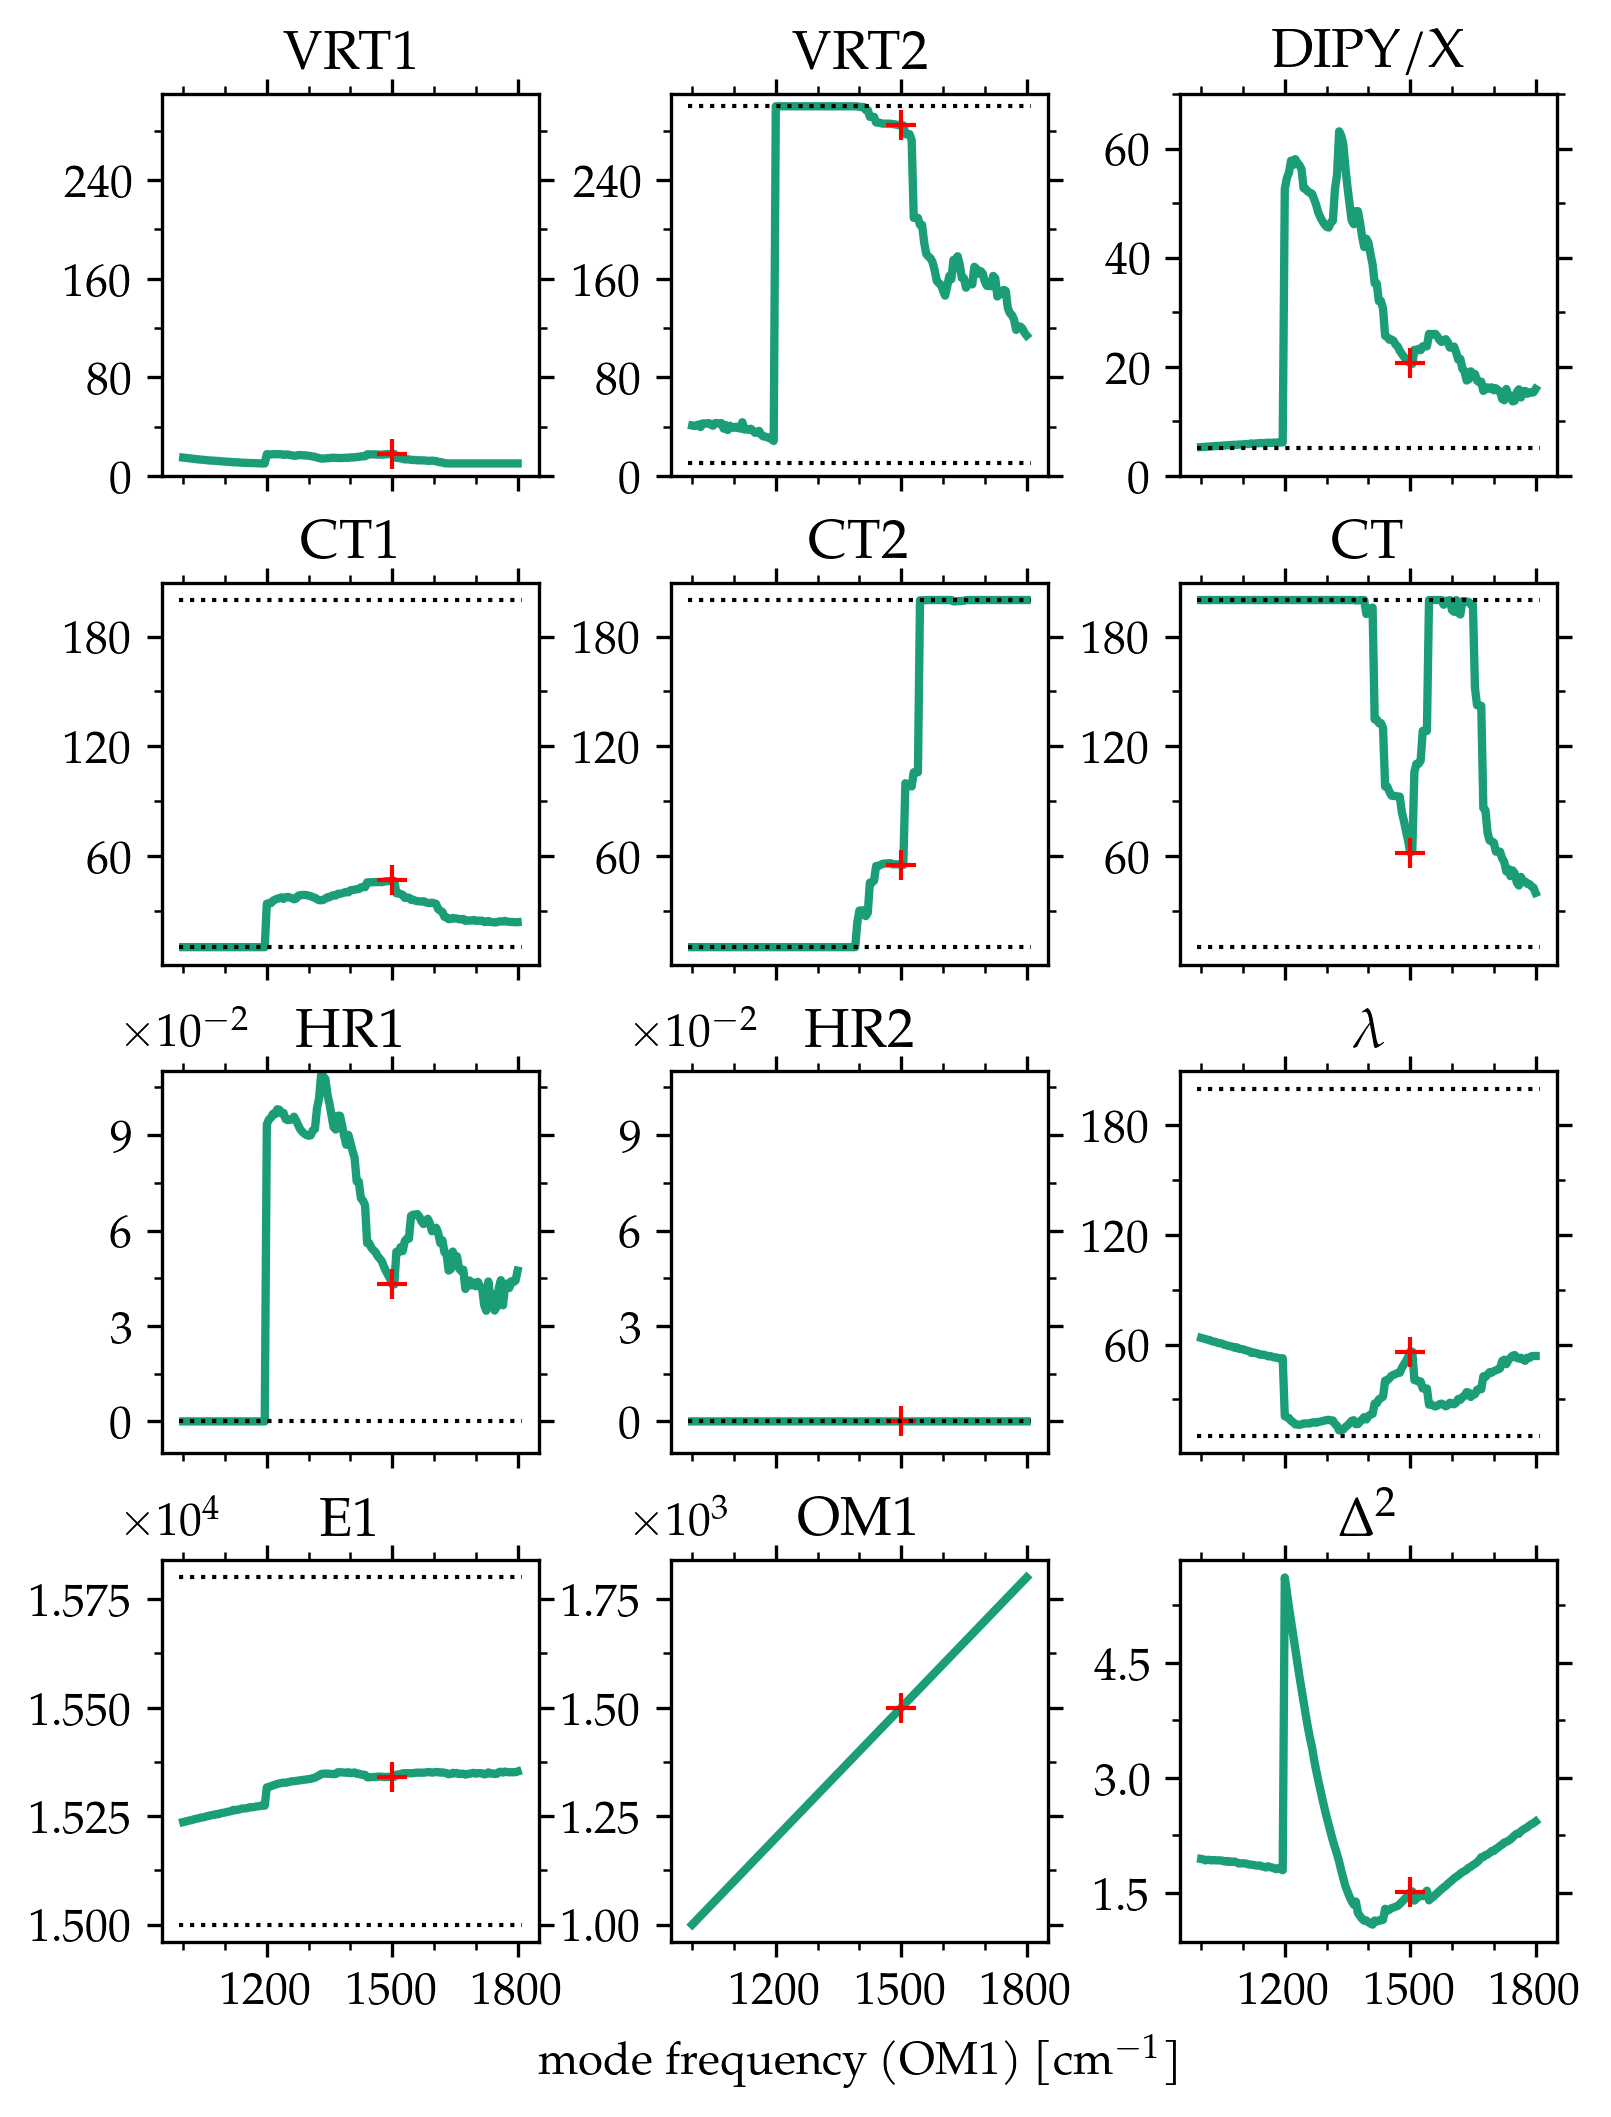

In [11]:
from matplotlib import cm
from spectre.matplotlib_latex import plt_latex, format_ticks

plt_latex()
clm = cm.get_cmap('viridis', len(files))

fig, grid = plt.subplots(4, 3, figsize=(6,8), dpi=300, sharex=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.28, wspace=0.35)

labels = list()

tt11 = list()
tt12 = list()
dipyx = list()
ct11 = list()
ct12 = list()
ct = list()
lamb = list()
hr11 = list()
hr12 = list()
e1 = list()
de = list()
om1 = list()
alpha = list()

for i, f in enumerate(sfiles[lim0:lim1]):
    filepath = os.path.join(path, f)
    optpars = spectre.utils.loadjson(filepath)
    datapath = filepath.replace('.json', '.npy')
    
    if os.path.isfile(datapath):
        data = np.load(datapath)
    else:
        syst, ta = spectre.full.init_system(optpars)
        spec = abss.calculate_abs_spectrum(syst, ta, optpars)
        spec.normalize()
        
        with qr.energy_units('1/cm'):
            data = np.vstack([spec.axis.data, spec.data])
            np.save(datapath, data)

    lab = f.split('.')[0].split('_')[2]
    labels.append(float(lab))

    tt11.append(optpars['scaled_OB_CF_vib_11']['target_time'])
    tt12.append(optpars['scaled_OB_CF_vib_12']['target_time'])
    dipyx.append(4.5**2 / optpars['dipx'][0]**2)
    ct11.append(optpars['scaled_OB_CF_vib_11']['cortime'])
    ct12.append(optpars['scaled_OB_CF_vib_12']['cortime'])
    ct.append(optpars['spectral_density_el']['cortime'])
    lamb.append(optpars['spectral_density_el']['reorg'])
    hr11.append(optpars['hr1'][0])
    hr12.append(optpars['hr1'][1])
    e1.append(optpars['energies'][1])
    de.append(optpars['energies'][2] - optpars['energies'][1])
    om1.append(optpars['omega'][0])
    alpha.append(optpars['dia_alpha1'])

ii = [i for i,x in enumerate(labels) if x == ivalue][0]

### Line & marker parameters
pars = dict(linewidth=2, )
mpars = dict(marker='+', c='r', markersize=7)
lpars = dict(linewidth=1, linestyle='dotted', c='k')


## TT11
grid[0,0].plot(labels, tt11, **pars)
grid[0,0].plot(labels[ii], tt11[ii], **mpars)
grid[0,0].set_title('VRT1')

## TT12
grid[0,1].plot(labels, tt12, **pars)
grid[0,1].plot(labels[ii], tt12[ii], **mpars)
grid[0,1].set_title('VRT2')
draw_line(grid[0,1], labels, 10, 300, **lpars)
          
## DIP Y/X
grid[0,2].plot(labels, dipyx, **pars)
grid[0,2].plot(labels[ii], dipyx[ii], **mpars)
grid[0,2].set_title('DIPY/X')
draw_line(grid[0,2], labels, 4.5**2 / 0.2**2, 4.5**2 / 2**2, **lpars)

## CT11
grid[1,0].plot(labels, ct11, **pars)
grid[1,0].plot(labels[ii], ct11[ii], **mpars)
grid[1,0].set_title('CT1')
draw_line(grid[1,0], labels, 10, 200, **lpars)

## CT12
grid[1,1].plot(labels, ct12, **pars)
grid[1,1].plot(labels[ii], ct12[ii], **mpars)
grid[1,1].set_title('CT2')
draw_line(grid[1,1], labels, 10, 200, **lpars)

## CT
grid[1,2].plot(labels, ct, **pars)
grid[1,2].plot(labels[ii], ct[ii], **mpars)
grid[1,2].set_title('CT')
draw_line(grid[1,2], labels, 10, 200, **lpars)

## HR11
grid[2,0].plot(labels, hr11, **pars)
grid[2,0].plot(labels[ii], hr11[ii], **mpars)
grid[2,0].set_title('HR1')
draw_line(grid[2,0], labels, 0.00001, 0.4, **lpars)

## HR12
grid[2,1].plot(labels, hr12, **pars)
grid[2,1].plot(labels[ii], hr12[ii], **mpars)
grid[2,1].set_title('HR2')
draw_line(grid[2,1], labels, 0.00001, 0.4, **lpars)

## lambda
grid[2,2].plot(labels, lamb, **pars)
grid[2,2].plot(labels[ii], lamb[ii], **mpars)
grid[2,2].set_title(r'$\lambda$')
draw_line(grid[2,2], labels, 10, 200, **lpars)

## e1
grid[3,0].plot(labels, e1, **pars)
grid[3,0].plot(labels[ii], e1[ii], **mpars)
grid[3,0].set_title('E1')
draw_line(grid[3,0], labels, 15000, 15800, **lpars)

## omega
grid[3,1].plot(labels, om1, **pars)
grid[3,1].plot(labels[ii], om1[ii], **mpars)
grid[3,1].set_title('OM1')
#draw_line(grid[3,1], labels, 0.00001, 0.4, **lpars)

# ## alpha
# grid[3,2].plot(labels, alpha, **pars)
# grid[3,2].plot(labels[ii], alpha[ii], **mpars)
# grid[3,2].set_title(r'$\alpha$')
# #draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)

## alpha
delta = (zax**2).sum(axis=1)
grid[3,2].plot(labels, delta, **pars)
grid[3,2].plot(labels[ii], delta[ii], **mpars)
grid[3,2].set_title(r'$\Delta^2$')
#draw_line(grid[3,2], labels, 0.00001, 0.4, **lpars)
    

grid[0,0].set_ylim(0,310)
grid[0,1].sharey(grid[0,0])
# grid[0,1].set_ylim(0,250)

#grid[1,0].set_ylim(0,100)
grid[1,1].sharey(grid[1,0])
grid[1,2].sharey(grid[1,0])
# grid[1,1].set_ylim(0,100)
# grid[1,2].set_ylim(0,100)

grid[2,0].set_ylim(-0.01, 0.11)
grid[2,1].sharey(grid[2,0])
# grid[2,1].set_ylim(-0.01, 0.075)

#grid[0,0].set_xlim(10, 80)
grid[0,2].set_ylim(0,70)

### TICKS
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator

for g in grid[:].flatten():
    pars = dict(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                bottom=True,           top=True,      left=True,      right=True,)
    #minor_pars = dict(bottom=True,           top=True,      left=True,      right=True)
    g.tick_params(which='both', **pars)
    #g.minor_tick_params(**minor_pars)
    
    g.xaxis.set_major_locator(MultipleLocator(300))
    g.xaxis.set_major_formatter('{x:.0f}')
    g.xaxis.set_minor_locator(MultipleLocator(100))
    g.yaxis.set_major_locator(MaxNLocator(nbins=4))
    g.yaxis.set_minor_locator(AutoMinorLocator(2))
    g.ticklabel_format(style='sci', axis='y', scilimits=(-1,3), useOffset=True)

    g.get_yaxis().set_offset_position("left")
    g.get_yaxis().OFFSETTEXTPAD = 7
    #g.get_yaxis().get_offset_text().set_position((-0.032,0))
    g.get_yaxis().get_offset_text().set_position((-0.097,0))

for g in grid[-1].flatten():
    pars = dict(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
    g.tick_params(which='both', **pars)

# plt.locator_params(axis='x', nbins=4)
# plt.locator_params(axis='y', nbins=4)
#fig.tight_layout()

grid[3,1].set_xlabel('mode frequency (OM1) [cm$^{-1}$]')